In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '..')

import os
import definition
from ner import Reader, Extractor, BiLstmCrfTagger, SingularBatchGenerator
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Validation

In [2]:
train_ratio = 0.75

raw_data = Reader.read_file(definition.DATA_PAIRED_SAMPLE)
index = np.arange(len(raw_data))
np.random.shuffle(index)
index_train = index[:int(train_ratio * len(raw_data))]
index_test = index[int(train_ratio * len(raw_data)):]
raw_data_train = np.array(raw_data)[index_train].tolist()
raw_data_test = np.array(raw_data)[index_test].tolist()

In [3]:
print(len(raw_data_train))
print(len(raw_data_test))

2025
675


In [68]:
label_train_flat = np.hstack([item['label'] for item in raw_data_train])
label_test_flat = np.hstack([item['label'] for item in raw_data_test])
label_count = np.unique(np.hstack((label_train_flat, label_test_flat)), return_counts=True)
label_count_total = sum(label_count[1])
print(label_count_total)
print(label_count[0])
print(label_count[1])
print([item/label_count_total for item in label_count[1]])

42861
['B-ASPECT' 'B-SENTIMENT' 'I-ASPECT' 'I-SENTIMENT' 'O']
[ 5143  6879  1694  3257 25888]
[0.11999253400527286, 0.160495555400014, 0.039523109586803856, 0.07598982758218427, 0.6039989734257251]


In [39]:
embedding_filename = "fasttext_25.bin"

extractor = Extractor(embedding_filename=os.path.join(definition.MODEL_UTILITY, embedding_filename))
X_train, y_train = extractor.extract_data(raw_data_train)
X_test, y_test = extractor.extract_data(raw_data_test)

Extracting data: 100%|███████████████████████████████████████████████████████████| 2025/2025 [00:01<00:00, 1418.35it/s]


Encoding model not found. It will be generated.


Extracting data: 100%|█████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 1326.94it/s]


In [40]:
filename_encoder_validation = "encoder_validation.pkl"

extractor.save_encoder_model(os.path.join(definition.MODEL_NER, filename_encoder_validation))

In [41]:
X_train[0].shape

(12, 75)

In [42]:
np.array(y_train[0]).shape

(12, 5)

In [43]:
n_features = X_train[0].shape[1]
n_lstm_unit = 100
n_distributed_dense = 50
n_tags = 5

print(n_features, n_lstm_unit, n_distributed_dense, n_tags)

75 100 50 5


In [44]:
model = BiLstmCrfTagger(n_features=n_features, n_lstm_unit=n_lstm_unit, n_distributed_dense=n_distributed_dense, n_tags=n_tags)

In [45]:
train_generator = SingularBatchGenerator(X_train, y_train)
val_generator = SingularBatchGenerator(X_test[:len(X_test)//3], y_test[:len(y_test)//3])

In [46]:
history = model.fit_generator(generator=train_generator, epochs=3, verbose=2, validation_data=val_generator)

Epoch 1/3
 - 118s - loss: 0.2669 - crf_accuracy: 0.8726 - val_loss: 0.1367 - val_crf_accuracy: 0.9033
Epoch 2/3
 - 115s - loss: 0.0093 - crf_accuracy: 0.9248 - val_loss: -1.1362e-02 - val_crf_accuracy: 0.9170
Epoch 3/3
 - 116s - loss: -1.6477e-01 - crf_accuracy: 0.9487 - val_loss: -8.8624e-02 - val_crf_accuracy: 0.9089


In [47]:
progress = pd.DataFrame(history.history)
progress

,val_loss,val_crf_accuracy,loss,crf_accuracy
0,0.136673,0.903273,0.266883,0.872560
1,-0.011362,0.916969,0.009342,0.924804
2,-0.088624,0.908946,-0.164769,0.948689


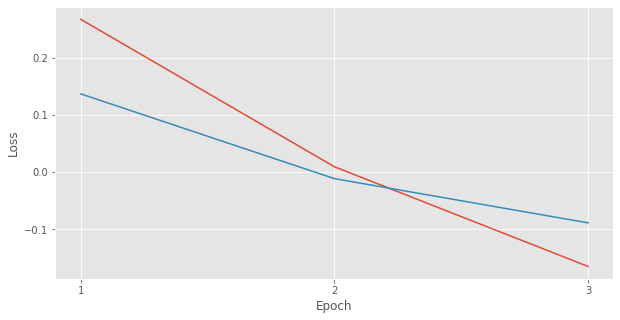

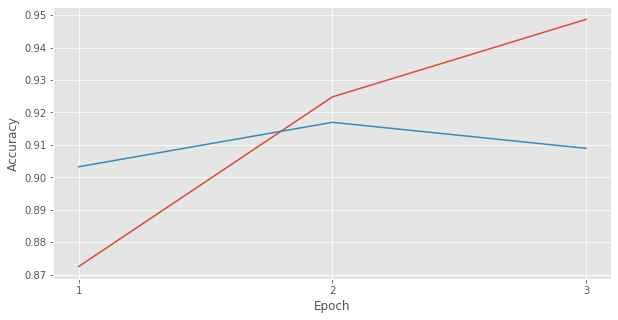

In [48]:
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(progress["loss"])
plt.plot(progress["val_loss"])
plt.xticks(range(len(progress)), progress.index+1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(progress["crf_accuracy"])
plt.plot(progress["val_crf_accuracy"])
plt.xticks(range(len(progress)), progress.index+1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 75)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 200)         140800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 50)          10050     
_________________________________________________________________
crf_3 (CRF)                  (None, None, 5)           290       
Total params: 151,140
Trainable params: 151,140
Non-trainable params: 0
_________________________________________________________________


In [50]:
filename_tagger_validation = "tagger_validation.h5"

model.save(os.path.join(definition.MODEL_NER, filename_tagger_validation))

In [51]:
pred = []
for item in tqdm(X_test):
    pred.append(model.predict(np.array([item]))[0])

100%|████████████████████████████████████████████████████████████████████████████████| 675/675 [00:13<00:00, 51.38it/s]


In [52]:
pred_label = extractor.convert_y_matrix_to_label(pred).tolist()
y_test_label = extractor.convert_y_matrix_to_label(y_test).tolist()

In [53]:
pred_label_flatten = [token for sentence in pred_label for token in sentence]
y_test_label_flatten = [token for sentence in y_test_label for token in sentence]

In [54]:
print(classification_report(y_test_label_flatten, pred_label_flatten))

              precision    recall  f1-score   support

    B-ASPECT       0.85      0.87      0.86      1254
 B-SENTIMENT       0.89      0.87      0.88      1679
    I-ASPECT       0.81      0.70      0.75       411
 I-SENTIMENT       0.80      0.78      0.79       767
           O       0.92      0.93      0.92      6575

    accuracy                           0.89     10686
   macro avg       0.85      0.83      0.84     10686
weighted avg       0.89      0.89      0.89     10686

